# Tak exploration

We want to build an AI for [Tak](http://cheapass.com/wp-content/uploads/2016/05/TakWebRules.pdf), a simple game that was inspired by the *Kingkiller Chronicles* by Patrick Rothfuss.  I'm not an AI expert (I'm not even a novice), so this will be an exploration, and attempt to try and develop a game AI, building from a small background.

## Tak rules:

The rules of Tak are fairly simple.  In principle, the game can by played on any square board, however in practice it is usually played on boards between 3x3 and 8x8 in size.

There are three kinds of pieces in Tak:
* Flat stones
* Standing stones (a flat stone that has been placed on its side)
* Capstones

Flat stones and standing stones are pulled from the same pool (called "stones"), while cap stones are different.  For the common board sizes, each player gets:

|          |3x3|4x4|5x5|6x6|8x8|
|----------|:-:|:-:|:-:|:-:|:-:|
|Stones    |10 |15 | 21| 30| 50|
|Capstones |0  |0  |  1|  1|  2|

There are two legal moves when playing:

#### placing a stone:  
A flat stone, a capstone or a standing stone can be placed at an empty place on the board.

#### moving:
This is where the complexity in the game comes from.  A legal move is made by picking up one or more pieces (up to n pieces on an nxn board) and droping at least one piece at each space as you move in a single direction across the board.  You cannot move past standing stones or capstones, unless 

In [384]:
from enum import Enum
import re

class TakBoard:
    class Piece(Enum):
        FLAT = 1
        STAND = 2
        CAP = 3
    class Player(Enum):
        ONE = 1
        TWO = 2
        def __str__(self):
            return "1" if self == TakBoard.Player.ONE else "2"
        
    def __init__(self, tps_string):
        import re
        tps_board, self.to_play, self.move = tps_string.lower().split(" ")
        self.move = int(self.move)
        self.to_play = TakBoard.Player(int(self.to_play))
        self.board_size = tps_board.count("/") + 1
        self.board = []
        for tps_row in tps_board.split("/"):
            row = []
            for tps_col in tps_row.split(","):
                # deal with blank spaces:
                if tps_col.startswith("x"):
                    if len(tps_col) > 1:
                        blanks = int(tps_col[1:])
                    else:
                        blanks = 1
                    row += [[] for _ in range(blanks)]
                # deal with pieces:
                else:
                    stack = []
                    for stone in re.findall("[12][sc]?", tps_col):
                        if len(stone) == 1:
                            stack.append((TakBoard.Piece.FLAT, TakBoard.Player(int(stone[0]))))
                        else:
                            stack.append((TakBoard.Piece.STAND if stone[1] == "s" else TakBoard.Piece.CAP, TakBoard.Player(int(stone[0]))))
                    row.append(stack)
            self.board.append(row)
            assert len(row) == self.board_size, f"len(row) = {len(row)} != self.board_size = {self.board_size}" 
        assert(len(self.board) == self.board_size)
        self.board.reverse()
        
    def __repr__(self):
        return str(self.board)
    
    def display(self):
        import matplotlib.pyplot as plt
        import matplotlib.patches as mpatches
        from matplotlib.collections import PatchCollection
        import numpy as np
        import string
        
        #fig = plt.figure(frameon=False)
        ax = plt.gca()
        
        row = np.array([0,1]*(self.board_size))
        row2 = row[1:self.board_size+1]
        row = row[:self.board_size]

        board = []
        for _ in range(0,self.board_size+1,2):
            board.append(row)
            board.append(row2)
        board = np.array(board[:self.board_size])
        board_image = ax.imshow(board, 
                                cmap=plt.cm.gray,
                                interpolation='nearest',
                                origin='lower')
        
        def stack_to_patches(stack, loc):
            x,y = loc
            patches = []
            for piece, player in stack:
                color = "0.5" if player == TakBoard.Player.TWO else "r"
                if piece == TakBoard.Piece.FLAT:
                    patches.append(mpatches.Circle((x,y),.3,facecolor=color, edgecolor="k"))
                if piece == TakBoard.Piece.STAND:
                    patches.append(mpatches.Rectangle((x-.3,y-.3),.5,.5,facecolor=color, edgecolor="k"))
                if piece == TakBoard.Piece.CAP:
                    patches.append(mpatches.RegularPolygon((x,y),5,.3,facecolor=color, edgecolor="k"))
                x += .1
                y += .1
            return patches
        
        patches = []
        for y,row in enumerate(self.board):
            for x,col in enumerate(row):
                if col == []:
                    pass
                else:
                    patches += stack_to_patches(col,(x,y))
        for patch in patches:
            ax.add_patch(patch)
        ax.set_yticklabels([str(y) for y in range(0,self.board_size+1)])
        ax.set_xticklabels([str(x) for x in ('a' + string.ascii_lowercase[:self.board_size+1])])
        plt.show()
        
    def place_piece(self, loc, piece):
        piece = (piece, self.to_play)
        x,y = loc
        if self[(x,y)] != []:
            raise IllegalMove(f"tried to place a {piece} on top of {row[x-1]}")
        else:
            self[(x,y)] = self[(x,y)] + [piece]
        return self
    
    def __getitem__(self,loc):
        x,y = loc
        return self.board[y-1][x-1]
    
    def __setitem__(self,loc,val):
        x,y = loc
        self.board[y-1][x-1] = val
    
    def move_pieces(self, start_loc, pieces_list, direction):
        from itertools import repeat
        from copy import deepcopy
        rollback_board = deepcopy(self.board)
        x,y = start_loc
        num = sum([n for n,_ in pieces_list])
        
        print(f"move: {start_loc}, {pieces_list}")
        
        row = self.board[y-1]
        
        #move right:
        locs = []
        
        if not (len(row[x-1]) >= num and num <= self.board_size):
            self.board = rollback_board
            raise IllegalMove("Tried to take more pieces than there are")
            
        if direction == ">":
            if not (self.board_size - x - 1 >= len(pieces_list)):
                self.board = rollback_board
                raise IllegalMove("Tried to move pieces off the board")

            locs = zip(range(x+1,x+len(pieces_list)+2),repeat(y))
            
        elif direction == "<":
            if not (x-1 >= len(pieces_list)):
                self.board = rollback_board
                raise IllegalMove("Tried to move pieces off the board")
                
            locs = zip(range(x-1,x-2-len(pieces_list),-1), repeat(y))
            
        elif direction == "+":
            if not (y + len(pieces_list) <= self.board_size):
                self.board = rollback_board
                raise IllegalMove("Tried to move pieces off the board")
                
            locs = zip(repeat(x), range(y+1,y+2+len(pieces_list)))
        
        elif direction == "-":
            if not (y - len(pieces_list) >= 0):
                self.board = rollback_board
                raise IllegalMove("Tried to move pieces off the board")
                
            locs = zip(repeat(x), range(y-1,y-2-len(pieces_list),-1))
            
        else:
            self.board = rollback_board
            raise IllegalMove("Doesn't match any move type")
        
        taken = self[(x,y)][-num:]
        self[(x,y)] = self[(x,y)][:-num]
        
        print(locs, pieces_list)
        i = 0
        
        for loc,(n,piece) in zip(locs,pieces_list):
            print("loop: ",loc, n, piece, self[loc], self[loc][-1] if self[loc] != [] else "")
            if self[loc] == []:
                self[loc] = self[loc] + taken[i:i+n]
            else:
                if self[loc][-1][0] == TakBoard.Piece.CAP:
                    self[(x,y)] = self[(x,y)] + taken
                    self.board = rollback_board
                    raise IllegalMove("can't place anything on top of capstone")
                    
                if self[loc][-1][0] == TakBoard.Piece.STAND:
                    print(f"stand: taken[i]: {taken[i]}, n: {n}, self[loc]: {self[loc]}")
                    if not (taken[i][0] == TakBoard.Piece.CAP and n == 1):
                        self.board = rollback_board
                        raise IllegalMove("can only place capstone on top of standing stone")
                    self[loc][-1] = (TakBoard.Piece.FLAT,self[loc][-1][1]) #flatten the standing stone
                    self[loc] = self[loc] + taken[i:i+n]
                else:
                    print(taken[i:i+n])
                    self[loc] = self[loc] + taken[i:i+n]
            print(self[loc])
            i += n
        return self
    
    def __repr__(self):
        tps_string = ""
        for y in reversed(range(1,self.board_size+1)):
            blanks = 0
            for x in range(1,self.board_size+1):                
                if self[(x,y)] == []:
                    blanks += 1
                else:
                    if blanks == 1:
                        tps_string += "x"
                        blanks = 0
                        if x != self.board_size and blanks == 0:
                            tps_string += ","
                    elif blanks > 1:
                        tps_string += "x" + str(blanks)
                        blanks = 0
                        if x != self.board_size and blanks == 0:
                            tps_string += ","
                    square_string = ""
                    for piece, player in self[(x,y)]:
                        square_string += "1" if player == TakBoard.Player.ONE else "2"
                    if piece == TakBoard.Piece.CAP:
                        square_string += "C"
                    elif piece == TakBoard.Piece.STAND:
                        square_string += "S"
                    tps_string += square_string
                    
                if x != self.board_size and blanks == 0:
                    tps_string += ","
            
            if blanks == 1:
                tps_string += "x"
                blanks = 0
                if x != self.board_size and blanks == 0:
                    tps_string += ","
            elif blanks > 1:
                tps_string += "x" + str(blanks)
                blanks = 0
                if x != self.board_size and blanks == 0:
                    tps_string += ","
                    
            if y != 1:
                tps_string += "/"
        
        tps_string += f" {self.to_play} {self.move}"
        
        return tps_string

In [385]:
t = TakBoard("x3,12,2S/x,22S,22C,11,21/121,212,12,1121C,1212S/21S,1,21,211S,12S/x,21S,2,x2 1 26")
repr(t) == "x3,12,2S/x,22S,22C,11,21/121,212,12,1121C,1212S/21S,1,21,211S,12S/x,21S,2,x2 1 26"

True

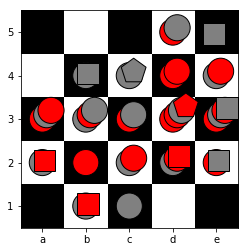

In [373]:
t.display()

In [318]:
class IllegalMove(Exception):
    def __init__(self, reason):
        self.reason = reason

class BadNotation(Exception):
    def __init__(self, reason):
        self.reason = reason


def parse_ptn(board, ptn_str):
    import re
    
    splits = re.split("[<>+-]",ptn_str)
    print(splits)

    if len(splits) == 1:
        return place_ptn(board, ptn_str)
    elif len(splits) == 2:
        return move_ptn(board, ptn_str)
    else:
        raise BadNotation("too many move direction identifiers")
        
def place_ptn(board, ptn_str):
    import string
    
    piece, col, row = re.match("([CSF]?)([a-z])(\d+)",ptn_str).group(1,2,3)
    
    piece = {'': TakBoard.Piece.FLAT, 
             'F': TakBoard.Piece.FLAT, 
             'S': TakBoard.Piece.STAND,
             'C': TakBoard.Piece.CAP}[piece]
    col = string.ascii_lowercase.find(col)+1
    row = int(row)
    return board.place_piece((col,row),piece)
        
def move_ptn(board, ptn_move):
    import string
    start_stone, direction, drop_list = re.split("([<>+-])",ptn_move)
    num, start_col, start_row = re.match("(\d*)([a-z])(\d+)", start_stone).group(1,2,3)
    places = [(int(n),
               {'': TakBoard.Piece.FLAT, 
                'F': TakBoard.Piece.FLAT, 
                'S': TakBoard.Piece.STAND,
                'C': TakBoard.Piece.CAP}[piece]
              ) for n, piece in 
              re.findall("(\d)([SC]?)",drop_list)]

    num = 1 if num == "" else int(num)
    if len(places) == 0:
        places = [(1,TakBoard.Piece.FLAT)]
        
    start_col = string.ascii_lowercase.find(start_col)+1
    start_row = int(start_row)
    #print(places, sum([n for n,_ in places]))
    assert sum([n for n,_ in places]) == num, BadNotation("dropped more pieces than were taken")
    
    return board.move_pieces((start_col, start_row), places, direction)

In [324]:
t = TakBoard("x3,12,2S/x,22S,22C,11,21/121,212,12,1121C,1212S/21S,1,21,211S,12S/x,21S,2,x2 1 26")

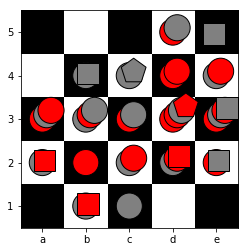

In [325]:
t.display()

['c5']


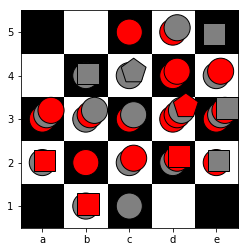

In [326]:
parse_ptn(t,"c5")
t.display()

In [327]:
parse_ptn(t,"c5-")

['c5', '']
move: (3, 5), [(1, <Piece.FLAT: 1>)]
<zip object at 0x7f01872d7408> [(1, <Piece.FLAT: 1>)]
loop:  (3, 4) 1 Piece.FLAT [(<Piece.FLAT: 1>, <Player.TWO: 2>), (<Piece.CAP: 3>, <Player.TWO: 2>)] (<Piece.CAP: 3>, <Player.TWO: 2>)


IllegalMove: can't place anything on top of capstone

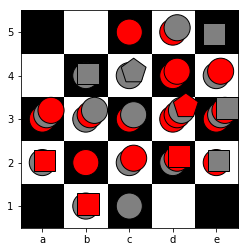

In [328]:
t.display()

['c5', '']
move: (3, 5), [(1, <Piece.FLAT: 1>)]
<zip object at 0x7f01871adb88> [(1, <Piece.FLAT: 1>)]
loop:  (2, 5) 1 Piece.FLAT [] 
[(<Piece.FLAT: 1>, <Player.ONE: 1>)]


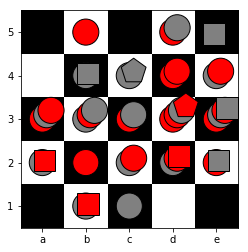

In [329]:
parse_ptn(t,"c5<")
t.display()

In [330]:
parse_ptn(t,"b5-")
t.display()

['b5', '']
move: (2, 5), [(1, <Piece.FLAT: 1>)]
<zip object at 0x7f0187122d88> [(1, <Piece.FLAT: 1>)]
loop:  (2, 4) 1 Piece.FLAT [(<Piece.FLAT: 1>, <Player.TWO: 2>), (<Piece.STAND: 2>, <Player.TWO: 2>)] (<Piece.STAND: 2>, <Player.TWO: 2>)
stand: taken[i]: (<Piece.FLAT: 1>, <Player.ONE: 1>), n: 1, self[loc]: [(<Piece.FLAT: 1>, <Player.TWO: 2>), (<Piece.STAND: 2>, <Player.TWO: 2>)]


IllegalMove: can only place capstone on top of standing stone